In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))
from utils import get_spike_activity, sdf, sdf_mean, sdf_maf
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as st
import pandas as pd

In [32]:
result_path = "/home/nomodel/code/NODS/results/grid_search/"
folder = 'grid_zoom_-3_-6/'
result_path = os.path.join(result_path,folder)
with open("/home/nomodel/code/NODS/network_configuration.json", "r") as json_file:
    net_config = json.load(json_file)

In [33]:
CS_burst_dur = net_config["devices"]["CS"]["parameters"]["burst_dur"]
CS_start_first = float(net_config["devices"]["CS"]["parameters"]["start_first"])
between_start = net_config["devices"]["CS"]["parameters"]["between_start"]
n_trials = net_config["devices"]["CS"]["parameters"]["n_trials"]
US_start_first = float(net_config["devices"]["US"]["parameters"]["start_first"])

In [35]:
cell = "pc_spikes"

grid_search = np.zeros((6,6))
grid_frequency = np.zeros((6,6))
grid_learning = np.zeros((6,6))
grid_baseline = np.zeros((6,6))

for i in range(0,6):
    for j in range(0,6):

        file_path = result_path + f"min{i}_plus{j}/"

        spk = get_spike_activity(cell_name=cell, path=file_path)
        sdf_mean_over_trials = []
        sdf_baseline = np.zeros((n_trials))
        sdf_cr = np.zeros((n_trials))
        for trial in range(n_trials):

            start = trial * between_start
            stop = CS_start_first + CS_burst_dur + trial * between_start

            sdf_cells = sdf(start=start, stop=stop, spk=spk, step=5)
            sdf_mean_trial = sdf_mean(sdf_cells)
            sdf_mean_over_trials.append(sdf_mean_trial)
            sdf_baseline[trial] = np.mean(sdf_mean_trial[100:150])
            sdf_cr[trial] = np.mean(sdf_mean_trial[250:300])

        sdf_change_baseline = sdf_baseline[1:] - sdf_baseline[1]
        sdf_change_cr = sdf_cr[1:] - sdf_cr[1]
    
        # learning in respect to the baseline
        grid_search[i-1,j-1] = (np.median(sdf_change_baseline[-10:]) - np.median(sdf_change_cr[-10:]))
        # pc frequency
        grid_frequency[i-1,j-1] = sdf_cr[-1]
        # percentage change baseline
        grid_baseline[i-1,j-1]  = (np.median(sdf_baseline[1:10])-np.median(sdf_baseline[-10:]))/np.median(sdf_baseline[1:10])*100
        # percentage learning CR
        grid_learning[i-1,j-1]  = (np.median(sdf_cr[1:10])-np.median(sdf_cr[-10:]))/np.median(sdf_cr[1:10])*100


/tmp/ipykernel_4428/326744223.py:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Trial")
/tmp/ipykernel_4428/326744223.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


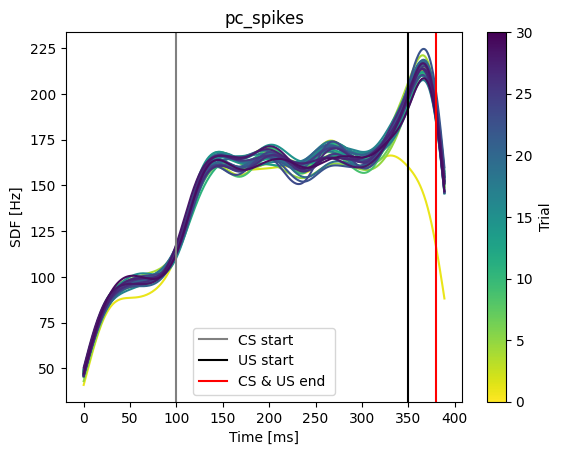

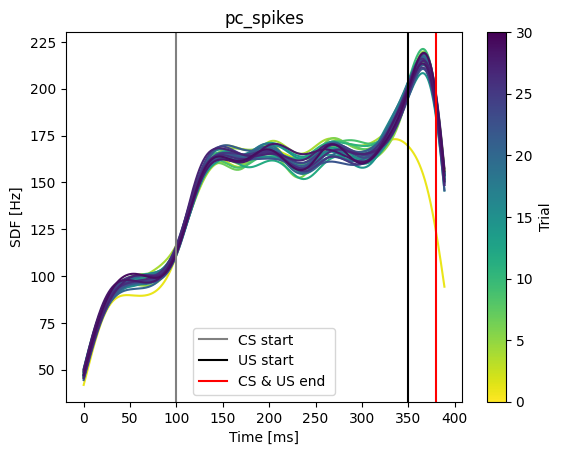

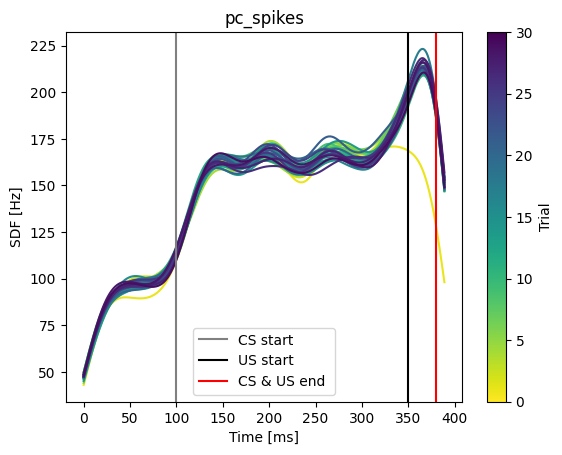

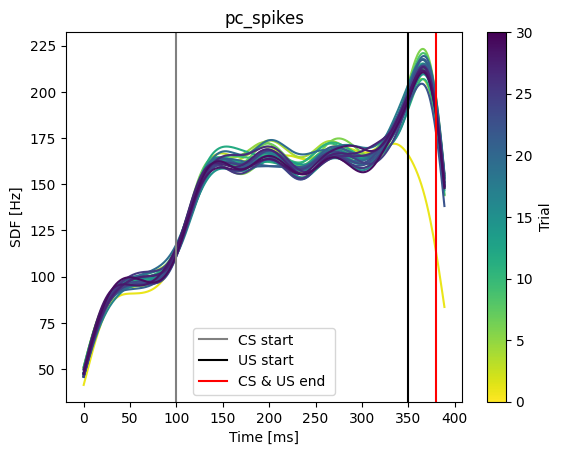

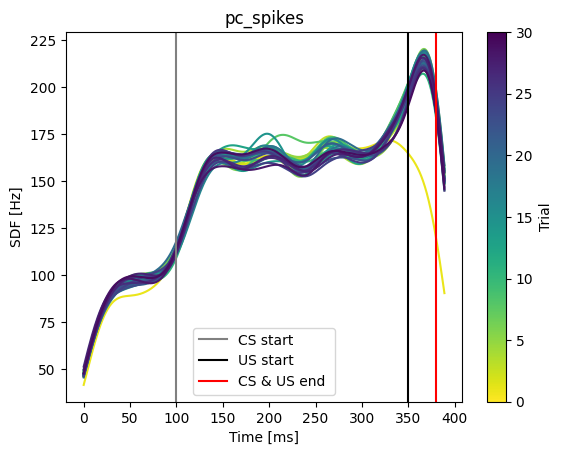

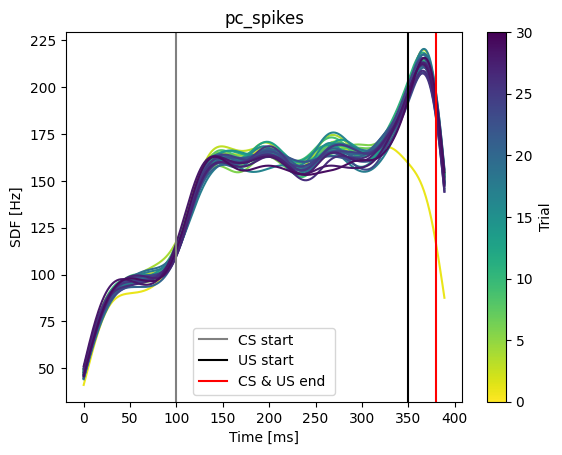

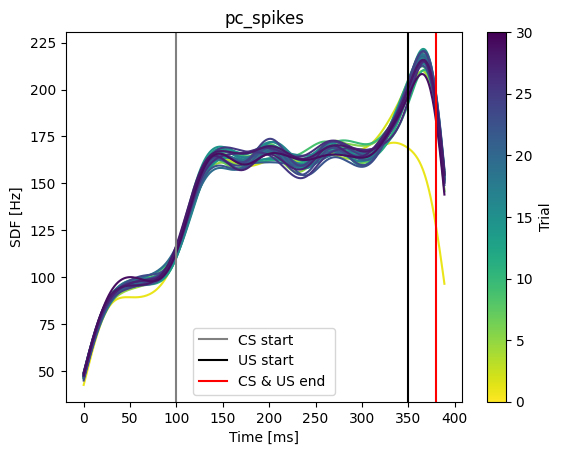

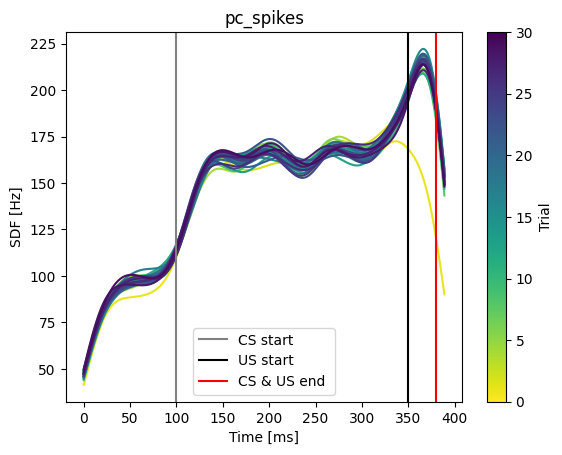

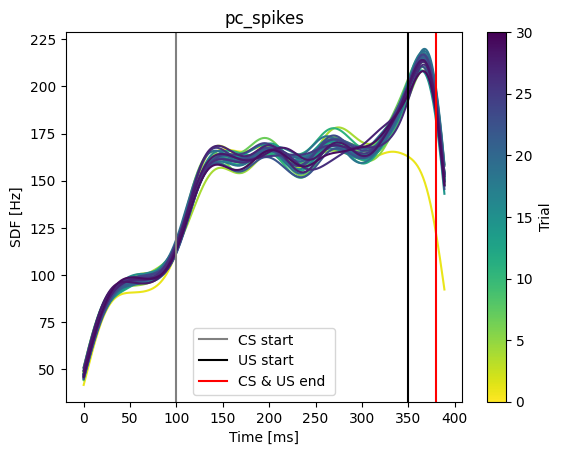

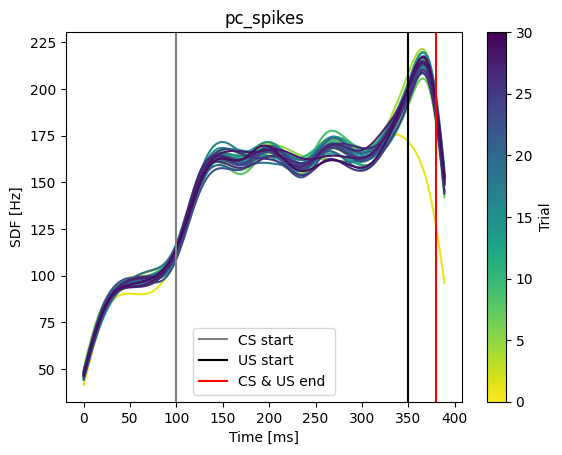

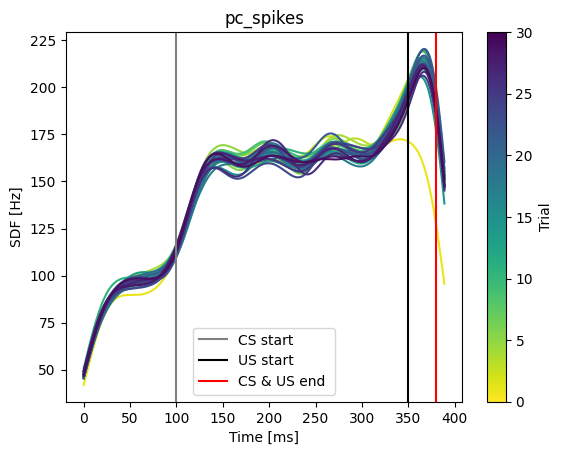

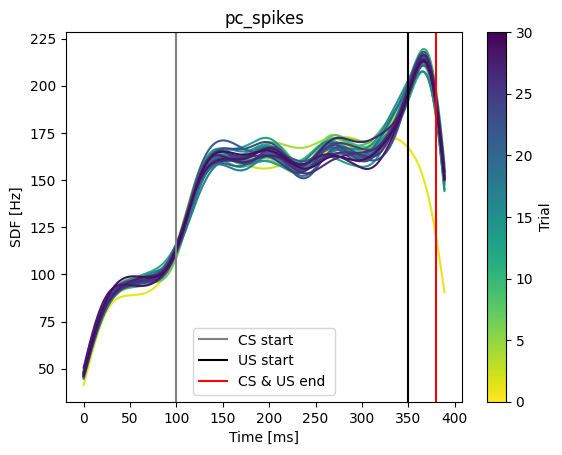

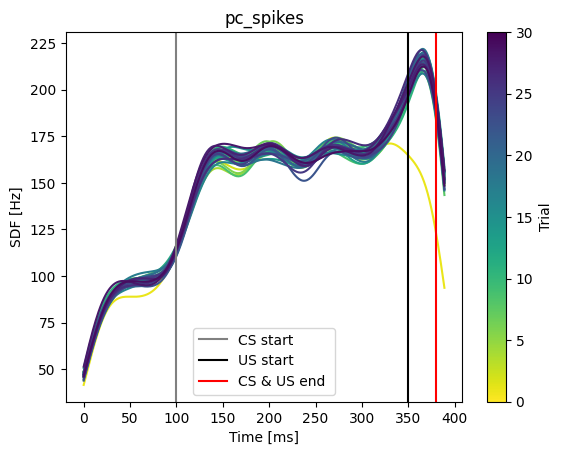

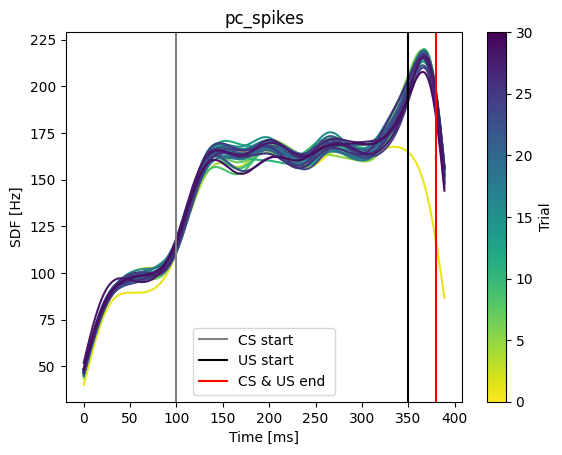

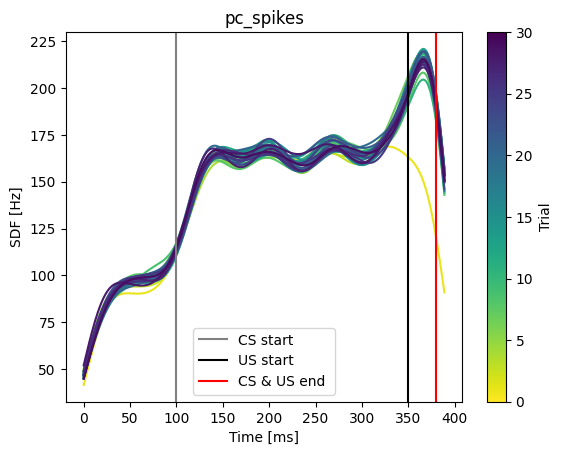

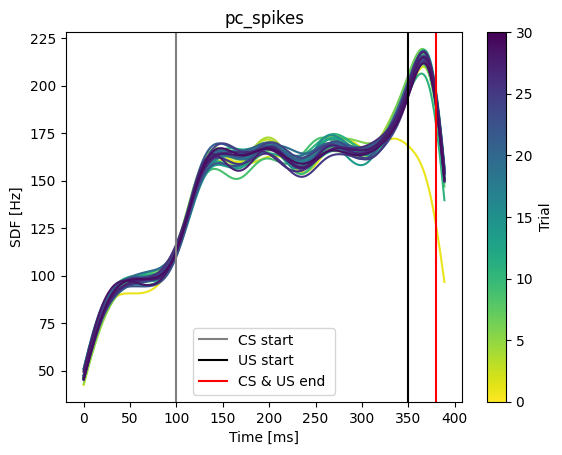

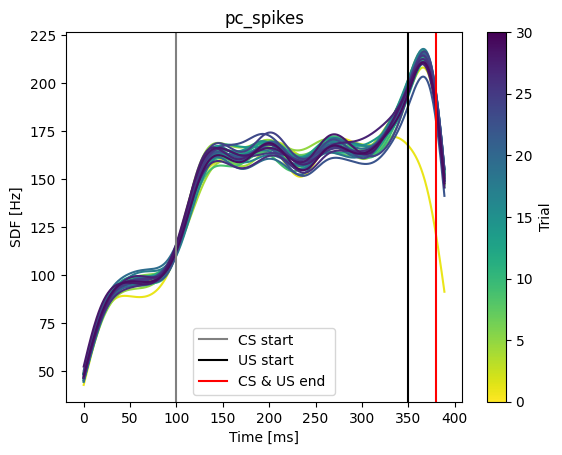

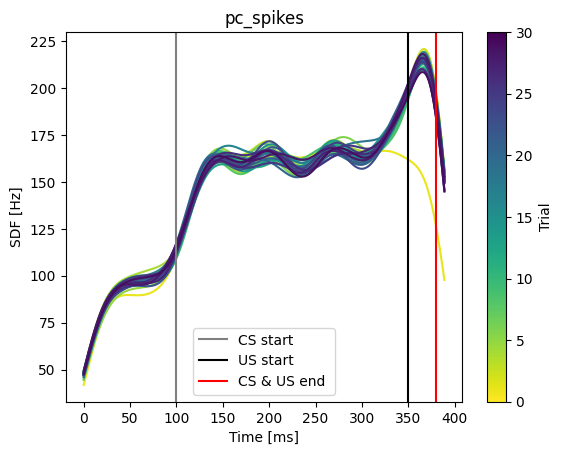

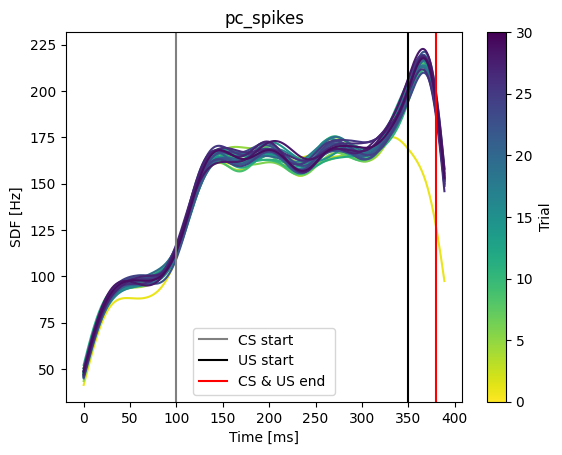

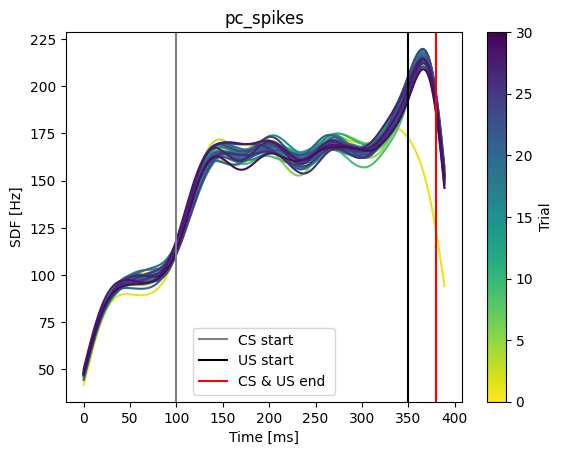

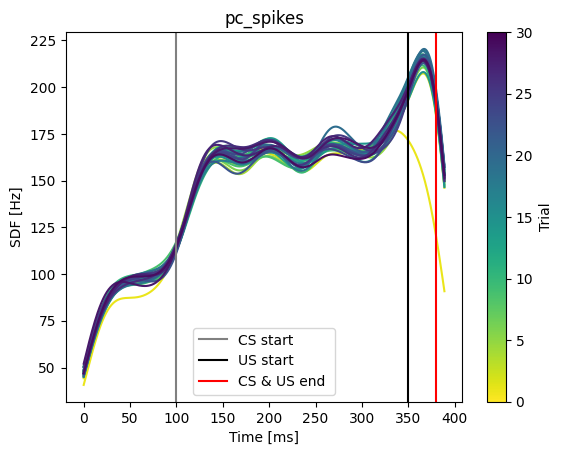

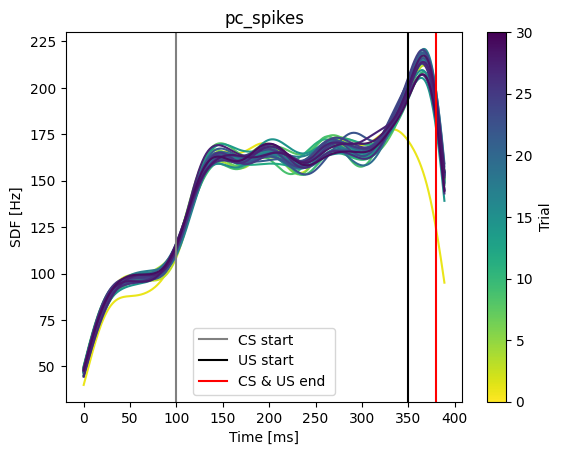

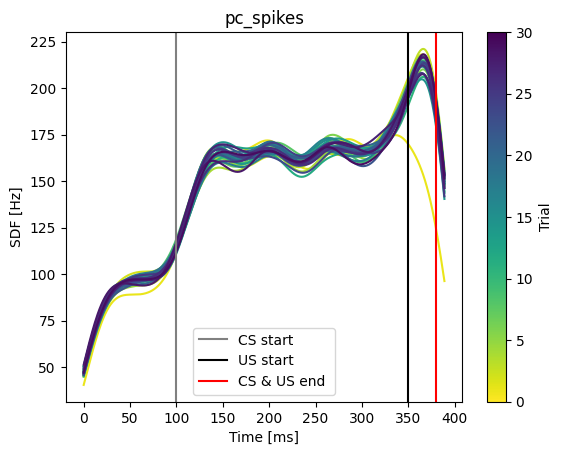

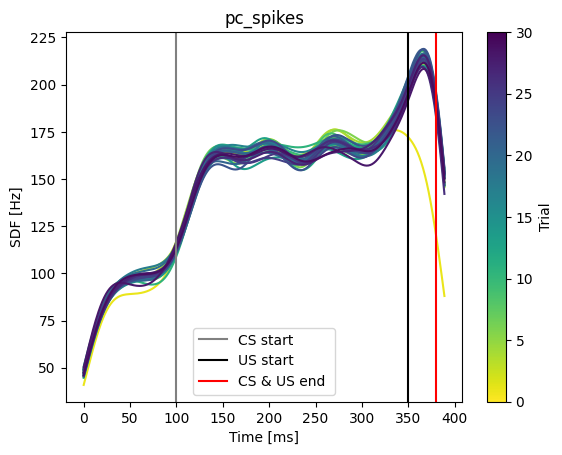

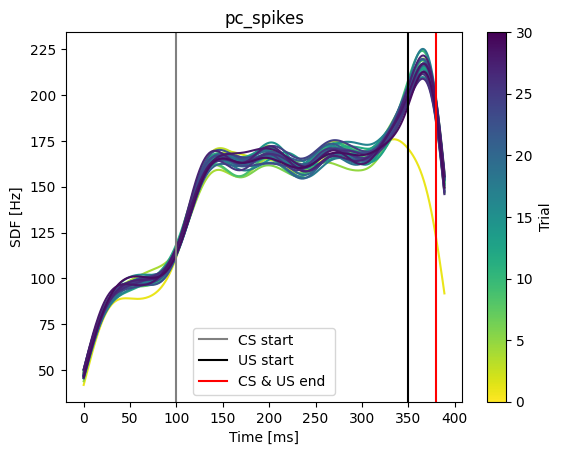

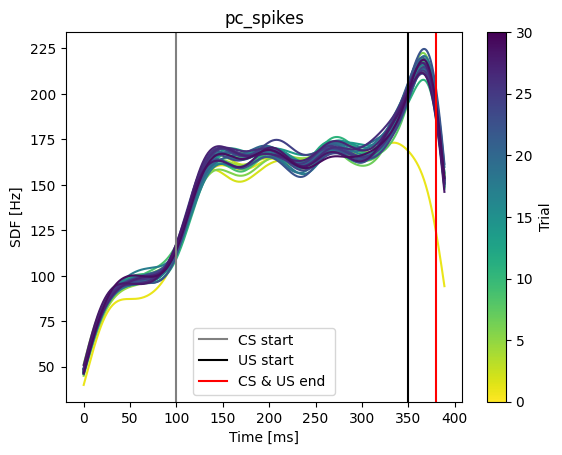

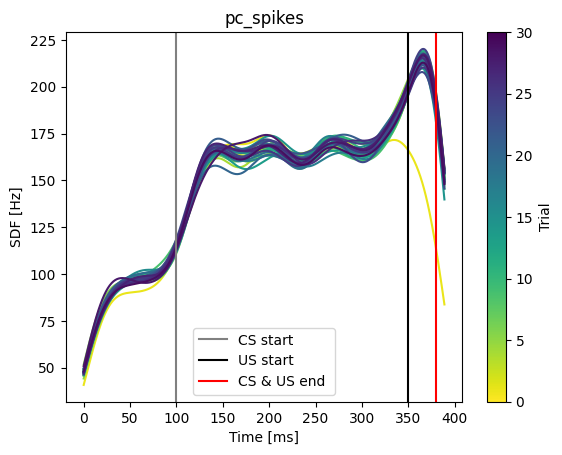

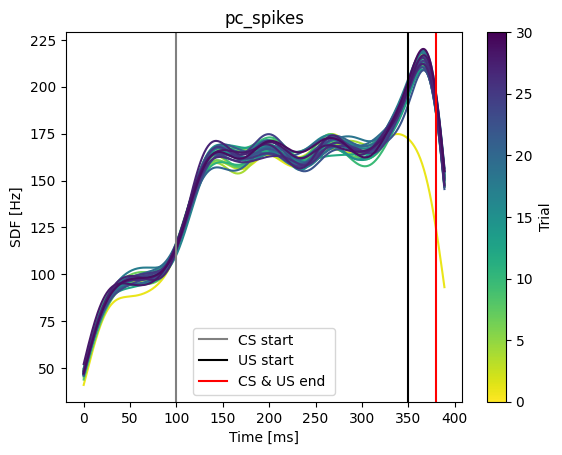

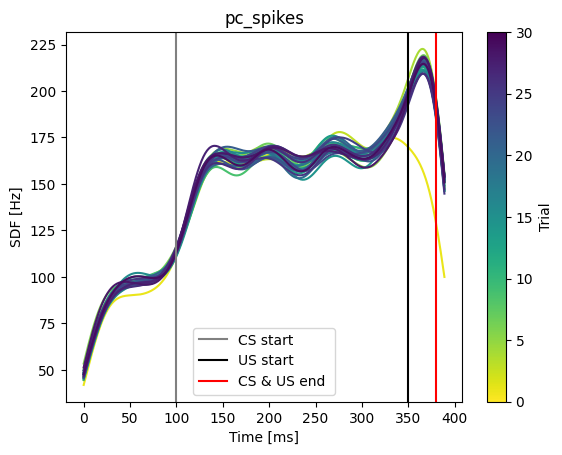

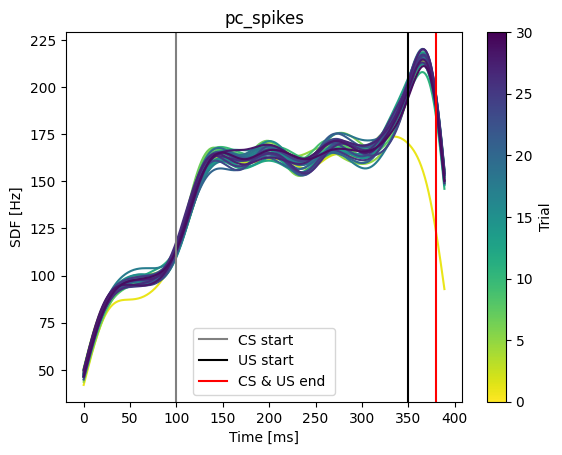

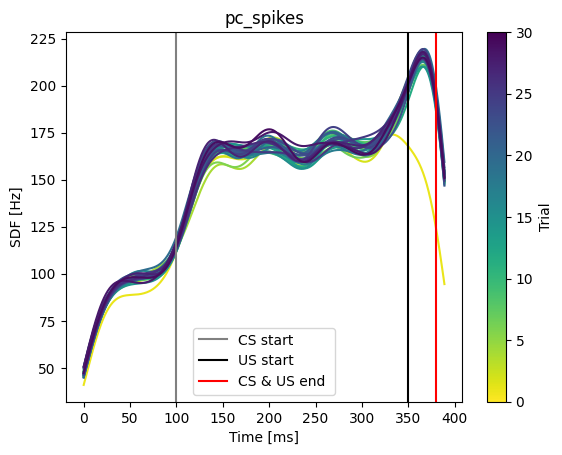

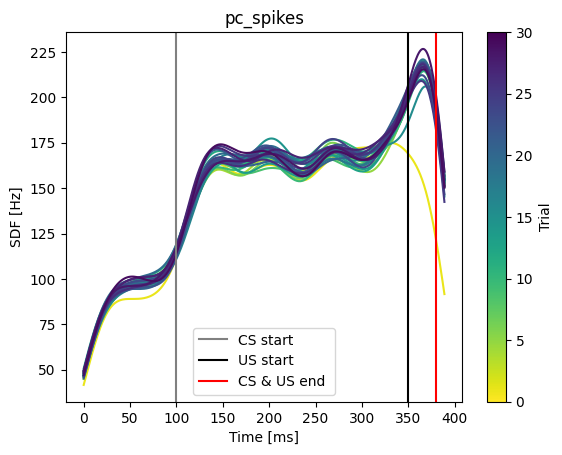

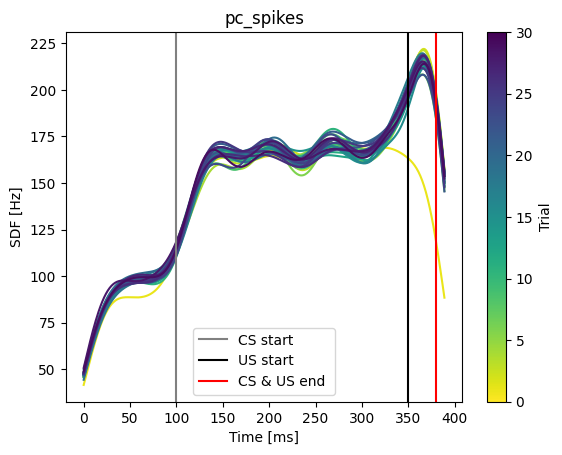

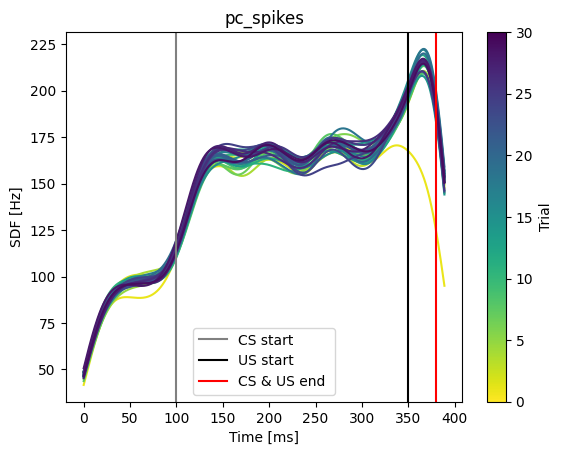

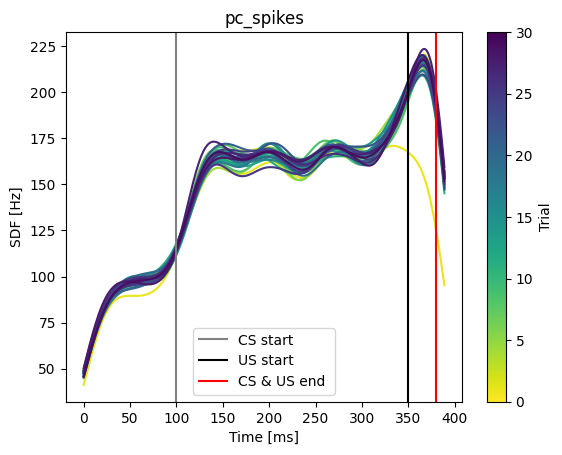

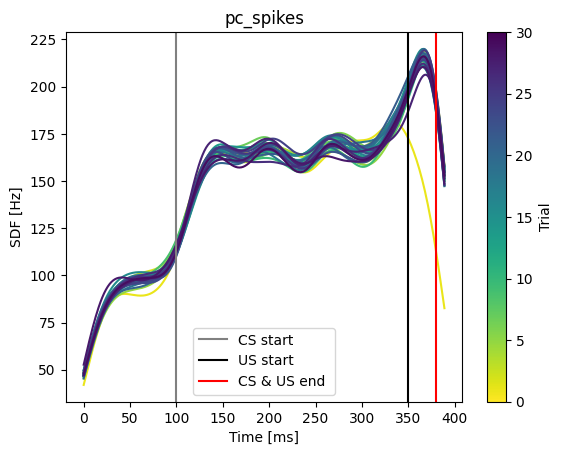

In [ ]:
for i in range(0,6):
    for j in range(0,6):

        file_path = result_path + f"min{i}_plus{j}/"
        spk = get_spike_activity(cell_name=cell, path=file_path)

        palette = list(reversed(sns.color_palette("viridis", n_trials).as_hex()))
        sm = plt.cm.ScalarMappable(
        cmap="viridis_r", norm=plt.Normalize(vmin=0, vmax=n_trials)
        )
        sdf_mean_cell = []
        sdf_maf_cell = []
        step = 5
        for trial in range(n_trials):
            start = trial * between_start
            stop = CS_start_first + CS_burst_dur + trial * between_start
            sdf_cell = sdf(start=start, stop=stop, spk=spk, step=step)
            sdf_mean_cell.append(sdf_mean(sdf_cell))
            sdf_maf_cell.append(sdf_maf(sdf_cell))

        fig = plt.figure()
        for trial in range(n_trials):
            plt.plot(sdf_mean_cell[trial], palette[trial])
        plt.title(cell)
        plt.xlabel("Time [ms]")
        plt.ylabel("SDF [Hz]")
        plt.axvline(CS_start_first, label="CS start", c="grey")
        plt.axvline(US_start_first - between_start, label="US start", c="black")
        plt.axvline(CS_start_first + CS_burst_dur, label="CS & US end ", c="red")
        plt.legend()
        plt.colorbar(sm, label="Trial")
        fig.savefig(os.path.join(result_path,'aa_sdf_{cell}_min{i}_plus{j}.png'))

In [ ]:
grid_search

array([[ 3.09941839,  0.33561221,  3.04372295,  4.55457461,  1.37700109,
         1.67660608],
       [-5.03798514, -0.69113475,  4.2649994 ,  3.24401335,  1.03107717,
         2.66890858],
       [-0.91095504, -0.56404804,  3.96350327, -0.04832103, -0.86895352,
        -2.50033488],
       [ 3.72015772,  1.55065963,  3.04091005,  2.30911967, -5.22760671,
         2.02668236],
       [-1.83848971,  1.31547911, -0.949612  , -1.36716458, -4.53120017,
         2.63718864],
       [-0.74456166,  3.16846917,  5.05331354,  3.226943  ,  6.16710494,
         6.36043634]])

In [ ]:
grid_frequency

array([[167.41127436, 164.80461495, 160.12511015, 162.28580812,
        161.07107693, 164.63430921],
       [168.36827422, 166.7015343 , 164.42905252, 164.96416089,
        165.09960094, 165.7408047 ],
       [167.00815191, 162.53262839, 164.20504986, 164.44642265,
        164.45450058, 168.35975151],
       [164.82091266, 165.35482795, 169.40069114, 166.99973152,
        166.09007429, 167.30343167],
       [167.35019172, 169.950355  , 170.98853969, 167.41332821,
        165.82736928, 166.79228521],
       [166.06211948, 162.58057998, 161.44015081, 164.63175428,
        157.26615496, 164.5963675 ]])

In [ ]:
grid_learning

array([[ 1.16154458,  0.62993555,  1.82673465,  1.53524188,  3.2005334 ,
         0.84081773],
       [-0.36044987, -0.15012512,  0.9108511 ,  0.91294315,  1.34345074,
         1.3284411 ],
       [-0.07246137,  0.16341536,  0.02473581, -0.54891421,  2.14234832,
        -1.56789807],
       [-0.20053122, -0.98797793, -0.64716274,  1.19711547, -0.29596632,
         0.56621635],
       [-1.46971363, -0.83640625, -1.38578761, -0.36032646,  0.6116629 ,
        -0.78851841],
       [ 0.79687897,  2.00923621,  1.33064795,  2.6208438 ,  3.13909808,
         0.13206952]])

/tmp/ipykernel_4428/116642113.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


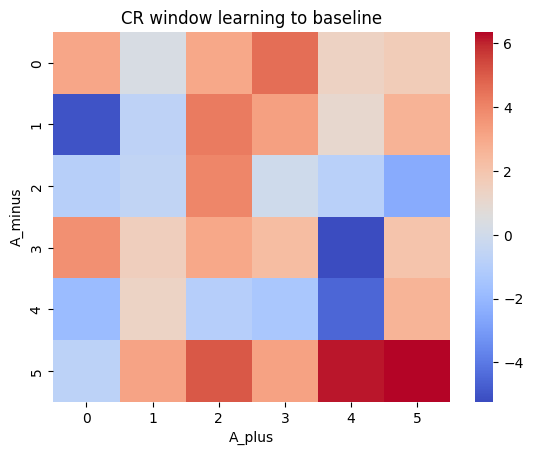

In [ ]:
cmap = plt.cm.get_cmap('coolwarm')
sns.heatmap(grid_search, cmap = cmap)
plt.xlabel('A_plus')
plt.ylabel('A_minus')
plt.title('CR window learning to baseline')
plt.savefig(os.path.join(result_path,'heatmap_baseline-CR'))

/tmp/ipykernel_4428/640804978.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


Text(0.5, 1.0, 'CR window learning to baseline')

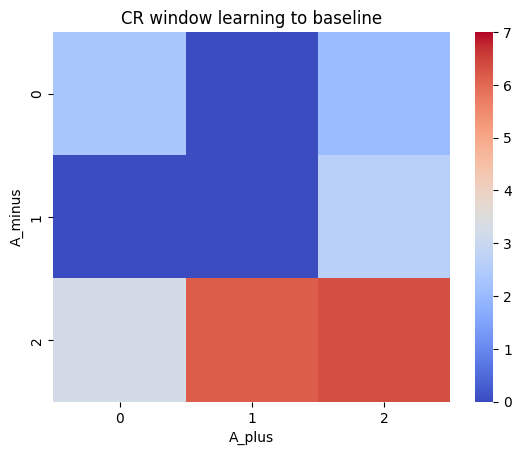

In [9]:
cmap = plt.cm.get_cmap('coolwarm')
sns.heatmap(grid_search[3:,3:], cmap = cmap, vmin = 0, vmax = 7)
plt.xlabel('A_plus')
plt.ylabel('A_minus')
plt.title('CR window learning to baseline')

/tmp/ipykernel_4428/1013634547.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('hot')


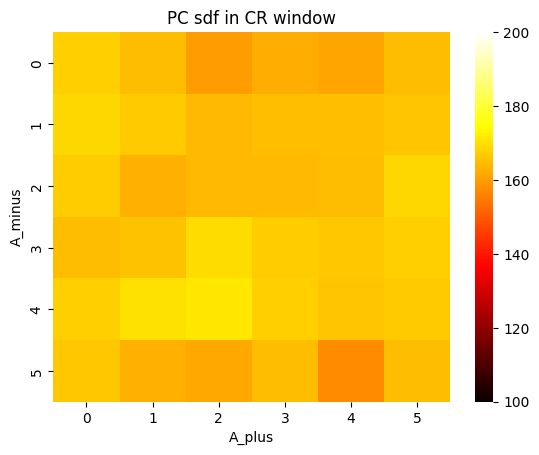

In [ ]:
cmap = plt.cm.get_cmap('hot')
sns.heatmap(grid_frequency, cmap = cmap, vmin = 100, vmax = 200)
plt.xlabel('A_plus')
plt.ylabel('A_minus')
plt.title('PC sdf in CR window')
plt.savefig(os.path.join(result_path,'heatmap_frequency_PC'))

/tmp/ipykernel_4428/1701739815.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('summer')


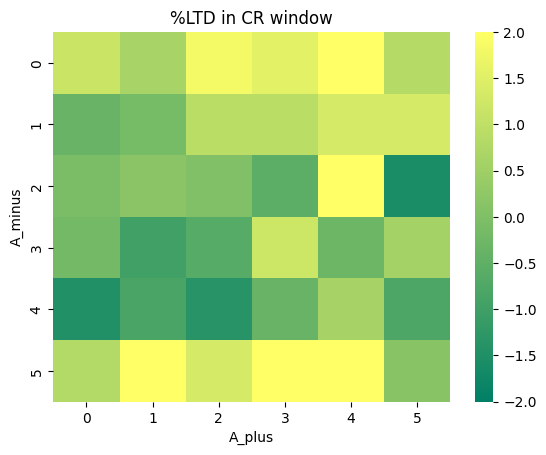

In [ ]:
cmap = plt.cm.get_cmap('summer')
sns.heatmap(grid_learning, cmap = cmap, vmin = -2, vmax = 2)
plt.xlabel('A_plus')
plt.ylabel('A_minus')
plt.title('%LTD in CR window')
plt.savefig(os.path.join(result_path,'heatmap_CR'))

/tmp/ipykernel_4428/1830988299.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('summer')


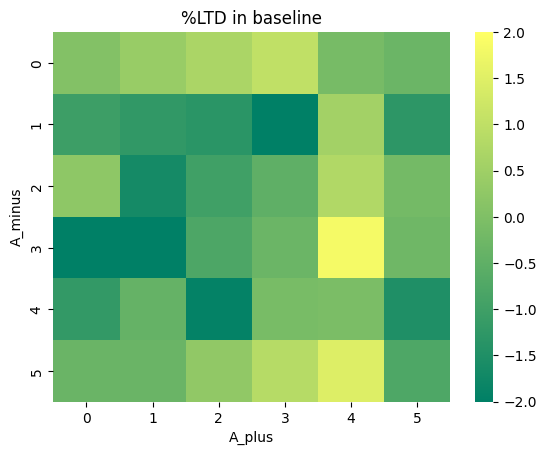

In [ ]:
cmap = plt.cm.get_cmap('summer')
sns.heatmap(grid_baseline, cmap = cmap, vmin = -2, vmax = 2)
plt.xlabel('A_plus')
plt.ylabel('A_minus')
plt.title('%LTD in baseline')
plt.savefig(os.path.join(result_path,'heatmap_baseline'))

In [24]:
np.logspace(-3,-6, 6)

array([1.00000000e-03, 2.51188643e-04, 6.30957344e-05, 1.58489319e-05,
       3.98107171e-06, 1.00000000e-06])

In [17]:
np.linspace(pow(10,-4),pow(10,-6), 6)

array([1.00e-04, 8.02e-05, 6.04e-05, 4.06e-05, 2.08e-05, 1.00e-06])

## A_minus = -0.0005
## A_plus = 0.0000225